In [1]:
from lms2.electric.maingrids import MainGrid
from lms2.electric.sources import PowerSource
from lms2.core.models import LModel
from lms2.core.time import Time

from pyomo.dae.contset import ContinuousSet
from pyomo.dae.plugins.finitedifference import TransformationFactory
from pyomo.environ import Objective, SolverFactory

import matplotlib
import matplotlib.pyplot as plt
from lms2.base.utils import pplot
import pandas as pd

matplotlib.use('Agg')

keywords are unexpanded, not using


/home/admin/Documents/02-Recherche/02-Python/lms2/venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  from ipykernel import kernelapp as app


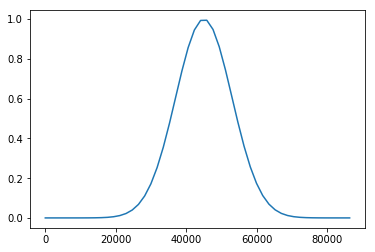

In [19]:
t = np.linspace(0, 86400, num=50, endpoint=True)
sigma = 8000
mu = 45000
import numpy as np

def irr(t):
    return np.exp( - (t - 45000)**2 / (2 * sigma**2))

Irr = [irr(i) for i in t]

serie = pd.Series(Irr, index=t)

serie.plot()

In [ ]:
m = LModel(name='model')
t = Time('00:00:00', '00:00:10', freq='1s')
m.t = ContinuousSet(bounds=(t.timeSteps[0], t.timeSteps[-1]))
t.nfe = int(t.delta/t.dt)

cin = pd.Series({0.0: 0.0, 10: 5})
cout = pd.Series({0.0: 1.0, 10: 6})

m.mg = MainGrid(time=m.t, cin=cin, cout=cout, pmax=20000, pmin=2000)

source = pd.Series({0.0: 0.0, 3: -5, 5: 5, 6:6, 8: -10, 10: 5})
m.ps = PowerSource(time=m.t, profile=source, flow_name='p')

m.connect_flux(m.mg.p, m.ps.p)

In [4]:
discretizer = TransformationFactory('dae.finite_difference')
discretizer.apply_to(m, wrt=m.t, nfe=t.nfe, scheme='BACKWARD')  # BACKWARD or FORWARD

In [5]:
m.obj = Objective(expr=m.mg.energy)
m.mg.energy.reconstruct()
m.mg.cost.reconstruct()
m.mg.pro.reconstruct()

Selection of the solver and optimization 

In [6]:
opt = SolverFactory('glpk')
results = opt.solve(m)


DatetimeIndex(['2018-11-27 00:00:00', '2018-11-27 00:00:01',
               '2018-11-27 00:00:02', '2018-11-27 00:00:03',
               '2018-11-27 00:00:04', '2018-11-27 00:00:05',
               '2018-11-27 00:00:06', '2018-11-27 00:00:07',
               '2018-11-27 00:00:08', '2018-11-27 00:00:09',
               '2018-11-27 00:00:10'],
              dtype='datetime64[ns]', freq='S')

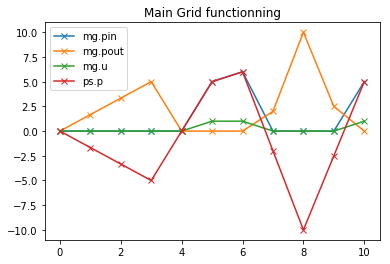

In [18]:
l, a, f = pplot(m.mg.pin, m.mg.pout, m.mg.u, m.ps.p,  legend=True, title='Main Grid functionning', Marker='x')


In [9]:
import networkx as nx

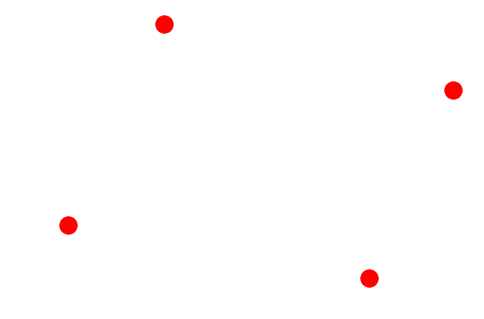

In [10]:
nx.draw(m.graph)